# I’m Something of a Painter Myself (Use GANs to create art - will you be the next Monet?)
Kaggle's [*GettingStarted Code Competition* for Generative Adversarial Networks (GANs)](https://www.kaggle.com/competitions/gan-getting-started/overview) requires us to build, train, and submit a deep-learning network for generating paintings in the style of *Monet*. This means that we must mimic the style of Monet, as they state more eloquently in the competition description:

> We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch! Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

## The Problem at Hand and Generative Adversarial Models (GANs)
We are tasked to build a GAN that can generate 7,000-10,000 Monet-Style Images. To understand how this task is posssible, we will first examine the typical architecture of a GAN model. From its name, GANs pit two models against each-other: There exists the **Generative Model $G$**, which generates fake data in an attempt to trick the **Discriminator Model $D$**, whose job is to determine whether a given data observation is *Real* or *Fake*. As such, the discriminator model is faced with a binary classification task, while the generative model is faced with the task of learning the true data's underlying distributions in order to produce the best replicas possible. This creates an interesting loss function as the discriminator model will want to maxmimize the probability of correctly distinguishing fake and real data, while the generative model will only want to maxmize the probability that the discriminator model classifies fake data as real data. There are a number of potential loss functions for GANS: the *Minimax GAN Loss* and the *Non-Saturating GAN Loss*, among others. Regardless of what GAN loss we utilize, the discriminator loss function will always be the same: the [Cross Entropy](https://www.wikiwand.com/en/Cross_entropy), which computes the entropy for one distribution, $Q(X)$, utilizing the weights for a separate distribution under the same support $\mathcal{X}$, $P(X)$. Thus, we can describe the loss function generally as
\begin{equation}
    H_{P, Q}(X) = \sum_{x \in \mathcal{X}} P(x) \log\left(\frac{1}{Q(x)}\right)
\end{equation}
By minimizing the cross entropy, we "adjust" the approximate probability distribution $Q(x)$ such that it aligns with the true probability distribution $P(x)$. We know if the cross entropy is minimized because the cross entropy will become equal to the entropy of our target distribution: $H_{P, Q}(X) = H_P(X) = \sum_{x \in X} P(x) \log\left(\frac{1}{P(x)}\right)$. This is equivalent to evaluating the relative entropy (i.e., KL-divergence) to 0 because $H_{P, Q}(X) = H_{P||Q}(X) + H_P(X)$, where we can interpret $H_{P||Q}(X)$ as the *amount of work* required of the distribution $Q(X)$ to match that of the distribution $P(X)$. In the binary classification case, recall that we want the discriminator to minimize the amount of false predictions, while the generator hopes to maximize the amount of false predictions.

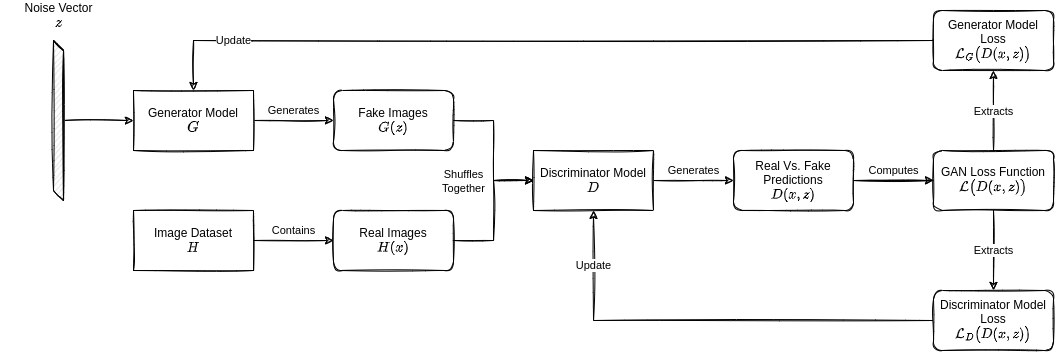

## Data Description
The `gan-getting-started` competition contains 4 separate directories, containing our data:
```
data/            403 MB
├── monet_jpg      6 MB
├── monet_tfrec   11 MB
├── photo_jpg    113 MB
└── photo_tfrec  273 MB
```

The `monet_jpg` contains 300 `.jpg` images of Monet paintings. The `photo_jpg` contains 7038 `.jpg` images of photos. The photos represent our testing dataset, which we submit for evaluation, while the Monet images are used for GAN training and validation. We will use the `monet_tfrec` and `photo_tfrec` files, which are stored in TFRecord format, allowing easy integration with TensorFlow and Keras. All images have an input size of `256 x 256 x 3`, where `3` represents the number of color channels. 

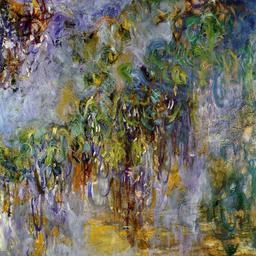
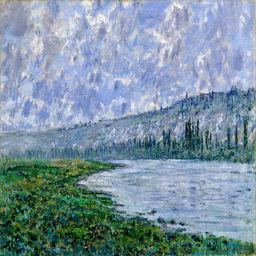
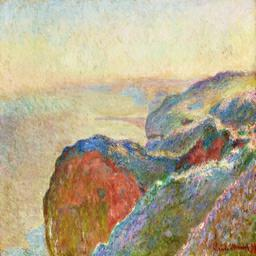
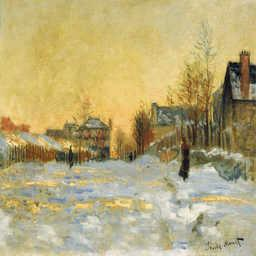

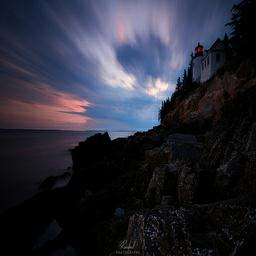
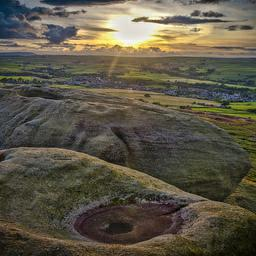
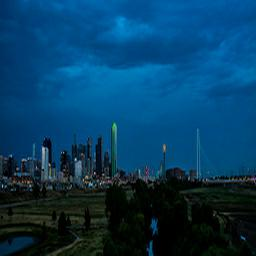
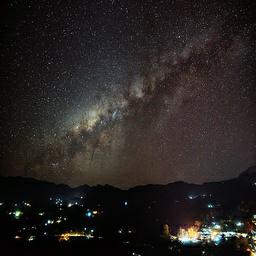

## Model Architecture(s)
The large image size means that there are $256 \times 256 \times 3 = 196,608$ features in each image observation. Working in such a high-dimensional feature-space will prove computationally difficult. Therefore, it will be necessary to make heavy use of convolutional layers. We will experiment with a number of different architectures.
## The Machine Learning Pipeline
Here, we formalize the machine learning pipeline, describing the sequential steps which are taken ensure that we have a performant, efficient, trainable, and deployable model:
1. In **Data Ingestion**, we will read in our `.tfrec` files of the Monet and photo images as `tf.data.Dataset` objects for increased efficiency in model I/O and computation.
2. In **Data Preprocessing**, we will apply standard image processing techniques such as normalization. Since the training set is small, our models will likely benefit from data augmentation techniques (such as re-sizing, rotating, and flipping) as well.
3. In **Data Exploration**, we explore some of the samples at hand and some summary statstics of our training set.
4. In **Model Building**, we prepare our neural networks: the generator, discriminator, and the generator-discriminator models. Since the generator cannot train while the discriminator is training, the generator-discriminator model is necessary where we make the generator untrainable.
5. In **Model Training and Validation**, we feed our models the training data and validate their performance with the validation data. Additionally, this is where we will define call-backs to stop the models from over- or under-fitting.
6. In **Model Evaluation and Submission**, we feed the photo data into the models, generate a `.zip` containing each of the model results, and submit it to Kaggle for evaluation
## Where to find this work
This work can be found in my GitHub repository, located here: [https://github.com/benjamin-ahlbrecht/monet-painter](https://github.com/benjamin-ahlbrecht/monet-painter).

# Data Ingestion

In [24]:
# Arrays and Linear Algebra
import numpy as np

# Tensors and GPU/TPU computation
import tensorflow as tf

# Neural Networks
from tensorflow import keras

# I/O operations
import os

# Data visualization
from matplotlib import pyplot as plt

In [68]:
@tf.function
def read_tfrecord(example:tf.Tensor):
    """Read in an image from a TFRecord example, decoding it with jpeg
    
    Parameters
    ----------
    example: tf.Tensor
        A single, serialized, scalar string tensor
    
    Returns
    -------
    image: tf.Tensor
        The decoded image
    """
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tf.image.decode_jpeg(example["image"], channels=3)
    return image
    

def ingest(data_dir:str):
    """Ingest the training and testing data.
    
    Parameters
    ----------
    data_dir: str
        The directory containing the `monet_tfrec/` and `photo_tfrec/` directories
    
    Returns
    -------
    dataset_monet: tf.data.Dataset
    dataset_photo: tf.data.Dataset
    """
    autotune = tf.data.AUTOTUNE
    
    dir_monet = f"{data_dir}/monet_tfrec"
    dir_photo = f"{data_dir}/photo_tfrec"

    fnames_monet = [f"{dir_monet}/{fname}" for fname in os.listdir(dir_monet) if fname.endswith(".tfrec")]
    fnames_photo = [f"{dir_photo}/{fname}" for fname in os.listdir(dir_photo) if fname.endswith(".tfrec")]
    
    # Decode Monet images and label with 1's so we know they're real
    dataset_monet = (
        tf.data.TFRecordDataset(fnames_monet)
        .map(lambda x: (read_tfrecord(x), 1), num_parallel_calls=autotune)
    )
    
    dataset_photo = (
        tf.data.TFRecordDataset(fnames_photo)
        .map(read_tfrecord, num_parallel_calls=autotune)
    )
    
    return (dataset_monet, dataset_photo)

In [80]:
DATA_DIR = "."
dataset_monet, dataset_photo = ingest(DATA_DIR)

# Data Exploration

In [88]:
def show_images(dataset:tf.data.Dataset, sqrt_n:int=4, index=None):
    """Show `(sqrt_n)**2` images of a tf.data.Dataset
    
    Parameters
    ----------
    dataset: tf.data.Dataset
    sqrt_n: int, default=4
        The square-root of the number of images to shown. For example, if sqrt_n=4,
        then 16 images will be shown (4 rows x 4 columns).
    index: None or int
        What index of a dataset sample the image is located on. If index=None, we
        assume the dataset has no labels.
    """
    dataset_iter = iter(dataset)
    
    fig, ax = plt.subplots(nrows=sqrt_n, ncols=sqrt_n, figsize=(4*sqrt_n,)*2, tight_layout=True)
    for i in range(sqrt_n):
        for j in range(sqrt_n):
            if index is None:
                ax[i, j].imshow(next(dataset_iter).numpy())
            else:
                ax[i, j].imshow(next(dataset_iter)[index].numpy())
            
            ax[i, j].axis("off")

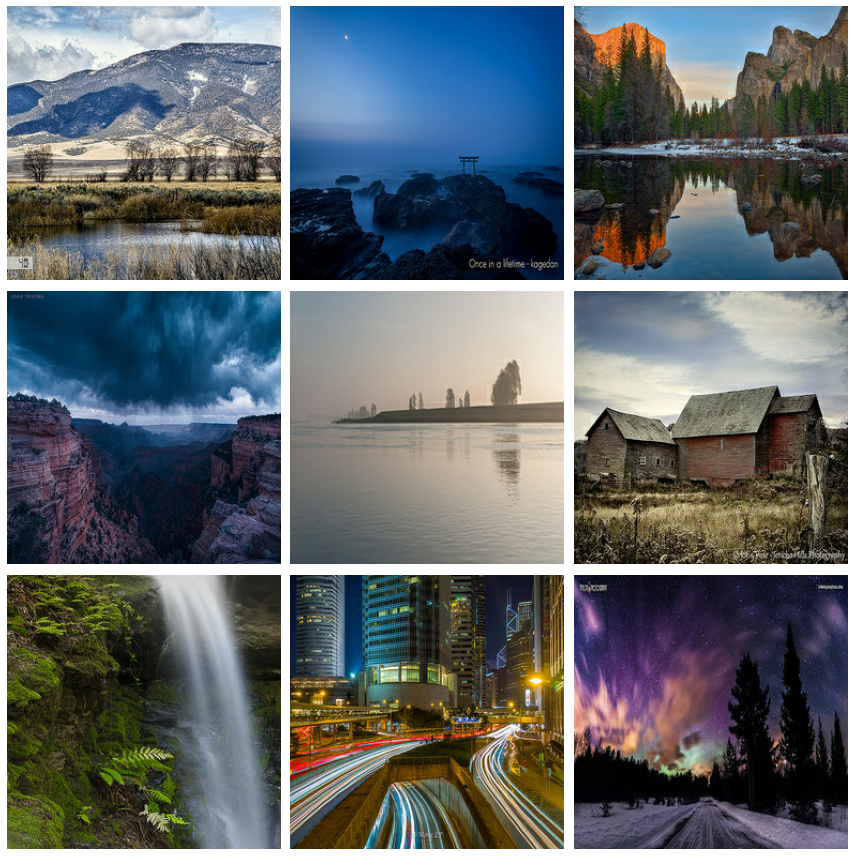

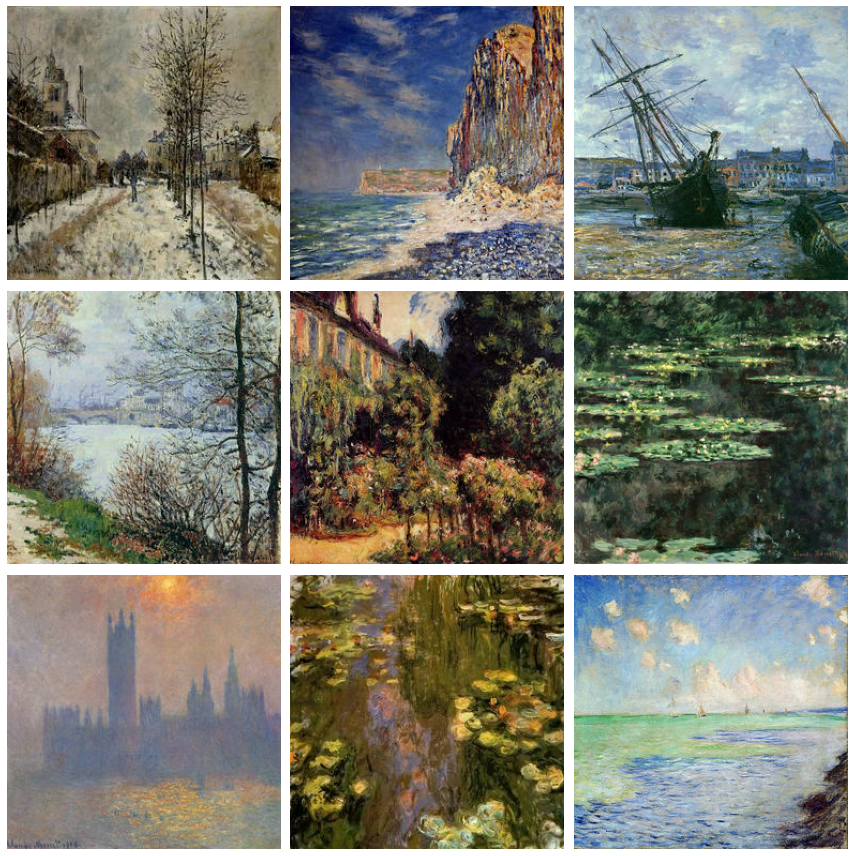

In [90]:
show_images(dataset_photo, sqrt_n=3, index=None)
show_images(dataset_monet, sqrt_n=3, index=0)

In [121]:
def get_class_counts(data_dir:str):
    """Return the counts for Monet and Photo images.
    
    Parameters
    ----------
    data_dir: str
        The directory containing the `monet_tfrec/` and `photo_tfrec/` directories
    """
    dir_monet = f"{data_dir}/monet_jpg"
    dir_photo = f"{data_dir}/photo_jpg"

    x = (0, 1)
    n_monet = len([fname for fname in os.listdir(dir_monet) if fname.endswith(".jpg")])
    n_photo = len([fname for fname in os.listdir(dir_photo) if fname.endswith(".jpg")])
    height = (n_photo, n_monet)
    tick_label = ("Photo Images", "Monet Images")
    
    fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.grid(True, color="black", alpha=0.2, ls="--", axis="y")
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Class")
    ax.bar(x=x, height=height, tick_label=tick_label)
    
    print(n_photo, n_monet)

7038 300


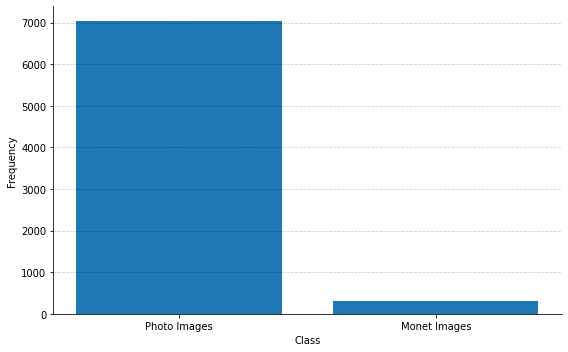

In [122]:
get_class_counts(DATA_DIR)

## Data Preprocessing

In [116]:
@tf.function
def normalize_image(image:tf.Tensor):
    """Normalize an image to [0, 1] from [0, 255]
    
    Parameters
    ----------
    image: tf.Tensor
    
    Returns
    -------
    image_normalized: tf.Tensor
    """
    image_normalized = tf.case(image, tf.float32) / 255.0
    return image_normalized
    
    
@tf.function
def expand_image(image:tf.Tensor):
    """Expand the last dimension of an image Tensor, so it works better
    with model fitting
    
    Parameters
    ----------
    image: tf.Tensor of shape (n, x, ..., y)
    
    Returns
    -------
    image_expanded: tf.Tensor of shape (n, x, ..., y, 1)
    """
    image_expanded = tf.expand_dims(image, axis=-1)
    return image_expanded
    
def preprocess(dataset_monet:tf.data.Dataset, dataset_photo:tf.data.Dataset, train_split:float=0.85):
    """Preprocess the Monet images and photos
    
    Parameters
    ----------
    dataset_monet: tf.data.Dataset
    dataset_photo: tf.data.Dataset
    train_split: float, default=0.85
        The percentage of the training data to reserve for training. The
        remainder will be placed into a validation set
    
    Returns
    -------
    dataset_train: tf.data.Dataset
    dataset_validation: tf.data.Dataset
    dataset_photo: tf.data.Dataset
    """
    autotune = tf.data.AUTOTUNE
    
    n_train = int(300 * train_split)
    
    dataset_full = (
        dataset_monet.map(normalize_image, num_parallel_calls=autotune)
        .map(expand_image, num_parallel_calls=autotune)
        .shuffle(n_train)
    )
    
    dataset_train = (
        dataset_full.take(n_train)
        .cache()
        .shuffle(n_train)
        .prefetch()
    )
    
    
    dataset_validation = (
        dataset_full.skip(n_train)
        .cache()
        .prefetch()
    )
    
    dataset_photo = (
        dataset_photo.map(normalize_image, num_parallel_calls=autotune)
        .map(expand_image, num_parallel_calls=autotune)
    )
    
    return (dataset_train, dataset_validation, dataset_photo)

In [ ]:
data = preprocess()

# Model Building

# Model Training and Validation

# Model Evaluation

())# Conclusion and Discussion

AttributeError: 'ParallelMapDataset' object has no attribute 'shape'